## Imports

In [145]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.arima_model import ARIMA

In [11]:
df_lapil42 = pd.read_csv('data/LAPIL42_final_selection.csv')

In [10]:
df_lapil42.head()

,speed,hour,TV/h,Dayofweek,PL/h,Vitesse du vent moyen 10 mn,VL/h,Variation de pression en 3 heures,Etat du sol,Température,Température minimale du sol sur 12 heures,date,congestion+30min
0,87.0,0,434.0,0,141.0,2.700000,293.0,80.000000,1.000000,287.950000,286.450000,2019-09-23 00:00:00,0
1,87.0,0,434.0,0,141.0,2.672726,293.0,76.713049,0.997336,287.919104,286.424860,2019-09-23 00:06:00,1
2,87.0,0,520.0,0,170.0,2.642294,350.0,73.491523,0.995162,287.886406,286.398089,2019-09-23 00:12:00,0
3,87.0,0,520.0,0,170.0,2.608704,350.0,70.335422,0.993478,287.851905,286.369686,2019-09-23 00:18:00,0
4,86.0,0,390.0,0,120.0,2.571957,270.0,67.244747,0.992285,287.815602,286.339653,2019-09-23 00:24:00,0


## Etapes 

- 3 méthodes ont été testées sur le capteurs LAPI L42 avec l'horizon de prédiction de 30 minutes :
    1. Par aggrégation des probabilités 
    2. Par vote 
    3. Par utilisation d'un modèle de forêt aléatoire
    

- La troisième méthode a été la plus efficace, nous l'avons donc appliqué à tout les capteurs et tous les horizons de temps dans un second temps.

## Echantillonage du jeu de données

In [12]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [13]:
Df = df_lapil42.drop(['congestion+30min', 'date'], axis = 1)
y = df_lapil42['congestion+30min']

In [14]:
n_total = len(df_lapil42)
n_test = 1500 #arbitrary
n_train = n_total - n_test

In [15]:
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of full training data points: X = (5220, 11), y = (5220,)
Number of validation data points: X = (1500, 11), y = (1500,)


## LAPIL42

### Modèles :

#### KNN

In [33]:
knn_model = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=1,
    metric='manhattan',
    metric_params=None,
    n_jobs=-1,
    )    

In [19]:
X_knn_train = X_train[['speed', 'hour']]

### Random Forest

In [20]:
randomforest_classifier = RandomForestClassifier(
    n_estimators = 10, 
    class_weight = "balanced", # Utilisation du paramètre "balanced" car nos classes sont inégales
    criterion = 'gini',  
    max_depth = 10, 
    min_samples_split = 40, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.5, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.2,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

In [278]:
X_rf_train = X_train

In [279]:
X_train.columns

Index(['timeseries', 'Bayes', 'régression logistique', 'random forest', 'knn'], dtype='object')

### Modèle Bayésien

In [80]:
model_Gaussian = GaussianNB()

In [81]:
X_gaussian_train = X_train[['speed', 'hour']]

In [82]:
model_Gaussian.fit(X_gaussian_train, y_train)

GaussianNB()

### Régression logistique

In [29]:
logistic_model = LogisticRegression(penalty='l1', class_weight= 'balanced', solver= 'liblinear', random_state=42)

In [28]:
X_logistic_train = X_train

## Agrégation

In [125]:
models = {model_Gaussian : X_gaussian_train, 
              logistic_model : X_logistic_train, 
              randomforest_classifier : X_rf_train,
              knn_model : X_knn_train
             }

### Agrégation par les probabilités

In [142]:
def proba_agregation(models = models, treshold = 0.5):
    
    array_test = np.array([(float(0), float(0))]*len(X_train))
    
    def reduction(x, treshold):
        if x > 4*treshold: return 0
        else: return 1


    for model in models.keys():
        model.fit(models[model], y_train)

        predictions = model.predict_proba(models[model])
        array_test += predictions

    final_predictions = np.vectorize(lambda t : reduction(t, treshold))(array_test)
    final_predictions = [prediction[0] for prediction in final_predictions]
                      
    return final_predictions


In [143]:
def treshold_selection(start, end, pas):
    f1_values = []
    for k in range(start, end, pas):
        pred = proba_agregation(models, k/100)
        f1 = metrics.f1_score(y_train, pred, sample_weight = None)
        f1_values.append(f1)
        
    plt.plot(f1_values)
    print([(k,v) for k,v in zip(f1_values, range(20, 90, 5))])

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: Conver

[(0.7358288770053476, 20), (0.7528795811518326, 25), (0.7876954109934442, 30), (0.7974497302599314, 35), (0.8236406619385341, 40), (0.8432183908045976, 45), (0.8518518518518517, 50), (0.8535714285714286, 55), (0.8529929577464789, 60), (0.8560277536860365, 65), (0.8540268456375839, 70), (0.8324066719618745, 75), (0.7843280849505675, 80), (0.7267886855241265, 85)]


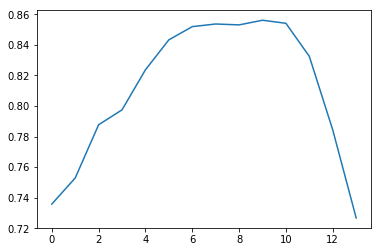

In [141]:
treshold_selection(20, 90, 5)

Gardons 0.5

### Agrégation par "vote"

In [198]:
Df_timeseries = df_lapil42['speed']
Df_timeseries.index = df_lapil42['date']

In [199]:
n_total = len(df_lapil42)
n_test = 1500 #arbitrary
n_train = n_total - n_test

In [481]:
X_train_timeseries, X_valid_timeseries = split_vals(Df_timeseries, n_train)

In [289]:
model=ARIMA(X_train_timeseries,order=(1,0,5))
model=model.fit()

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information

In [202]:
timeseries_array = model.predict(X_train_timeseries.index[0]).apply(lambda x : congestion(x)).values

In [164]:
def congestion(x):
    if x > 80: return 0
    else: return 1

In [177]:
def reduction_vote(t):
    if t > 2: return 1
    else: return 0

In [193]:
array_test = timeseries_array

for model in models.keys():
    model.fit(models[model], y_train)

    predictions = model.predict(models[model])
    array_test += predictions

final_predictions = np.vectorize(lambda t : reduction_vote(t))(array_test)
                      
final_predictions

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([0, 0, 0, ..., 1, 1, 1])

In [194]:
metrics.f1_score(y_train, final_predictions, sample_weight = None)

0.8428635749662313

## Agrégation par Forêt aléatoire

### reconstitution d'un DataFrame 

In [218]:
timeseries_array = model.predict(X_train_timeseries.index[0]).apply(lambda x : congestion(x)).values

In [222]:
df_preds = pd.DataFrame(timeseries_array)

In [238]:
df_preds.index, _ = split_vals(df_lapil42['date'], n_train)

In [241]:
df_preds.columns = ['timeseries']

In [244]:
for model in models.keys():
    model.fit(models[model], y_train)
    predictions = model.predict(models[model])
    df_preds[model] = predictions


/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [246]:
df_preds.columns = ['timeseries','Bayes', 'régression logistique', 'random forest', 'knn', 'Y_train']

In [255]:
y_train.index, _ = split_vals(df_lapil42['date'], n_train)

In [256]:
df_preds['Y_train'] = y_train

### Utilisation des modèles

In [265]:
X_train = df_preds.drop(['Y_train'], axis = 1)

In [262]:
y_train = df_preds['Y_train']

In [264]:
classifier = RandomForestClassifier(
    n_estimators = 20, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

In [268]:
classifier.fit(X_train, y_train)
classifier_metrics(y_train, classifier.predict(X_train))

Accuracy : 95.08%
Recall : 80.77%
Precision : 96.27%
F1-score : 87.84%


/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


## Tuning

In [271]:
classifier = RandomForestClassifier(
    n_estimators = 50, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 3, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.5, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = 0.5,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

In [274]:
classifier.fit(X_train, y_train)
classifier_metrics(y_train, classifier.predict(X_train))

Accuracy : 95.08%
Recall : 80.77%
Precision : 96.27%
F1-score : 87.84%


In [275]:
cv_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring= 'f1')
cv_score.mean()

0.8777233375499629

# TOUS LES CAPTEURS + TOUS LES HORIZONS DE TEMPS

L'aggrégation par Random Forest semblait la plus prometteuse, nous gardons donc cette méthode pour la suite : 

In [331]:
df_n230 = pd.read_csv('data/df_n230_final.csv')
df_n230.drop(['date.1', 'date.1.1'], axis = 1, inplace = True)

In [450]:
dirty_idx = [23]
df_n230 = df_n230[~df_n230.index.isin(dirty_idx)]

In [336]:
df_n230.columns

Index(['date', 'sensor', 'TV/h', 'speed', 'pression au niveau de la mer',
       'Variation de pression en 3 heures', 'Vitesse du vent moyen 10 mn',
       'Température', 'Point de rosée', 'Visibilité horizontale',
       'Nébulosité des nuages de l'étage inférieur',
       'Variation de pression en 24 heures',
       'Température minimale du sol sur 12 heures', 'Etat du sol',
       'Hauteur de la neige fraiche', 'Précipitation dans la dernière heure',
       'year', 'month', 'day', 'hour', 'minutes', 'congestion+30min',
       'congestion+60min', 'congestion+3heures', 'congestion+24heures'],
      dtype='object')

In [437]:
classifier_tuned_aggregation = RandomForestClassifier(
    n_estimators = 50, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 3, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.5, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = 0.5,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

N_TRAIN = 5220
model = dict()

model_arima = ARIMA(X_train_timeseries,order=(1,0,5))
model_arima = model_arima.fit()

def pred(capteur, horizon):

    df = df_n230[df_n230['sensor'] == capteur]
    y = df[horizon].apply(lambda x: congestion(x))

    models[model_Gaussian] = ['speed', 'hour']
    models[knn_model] = ['speed', 'hour']
    models[logistic_model] = ['speed', 'hour', 'TV/h',
     'Vitesse du vent moyen 10 mn', 'Variation de pression en 3 heures', 'Etat du sol', 'Température',
     'Température minimale du sol sur 12 heures']
    models[randomforest_classifier] = models[logistic_model]

    X_train, X_valid = split_vals(df.drop(['date', 'congestion+30min', 'congestion+60min', 'congestion+3heures', 'congestion+24heures'], axis = 1), N_TRAIN)
    y_train, y_valid = split_vals(y, N_TRAIN)

    #construction du nouveau df pour la forêt aléatoire d'agrégation :

    timeseries_array = model_arima.predict(X_train_timeseries.index[0]).apply(lambda x : congestion(x)).values

    df_preds = pd.DataFrame(timeseries_array)
    df_preds.index, _ = split_vals(df_lapil42['date'], N_TRAIN)

    for model in models.keys():
        model.fit(X_train[models[model]], y_train)
        predictions = model.predict(X_train[models[model]])
        df_preds[str(model)] = predictions
        
    y_train.index, _ = split_vals(df_lapil42['date'], n_train)
    
    df_preds['y_train'] = y_train



    #modèle
    
    X_train_aggregation = df_preds.drop(['y_train'], axis = 1)
    y_train_aggregation = df_preds['y_train']
    
    classifier_tuned_aggregation.fit(X_train_aggregation, y_train_aggregation)
    y_preds = classifier_tuned_aggregation.predict(X_train_aggregation)
    return metrics.f1_score(y_train_aggregation, y_preds, sample_weight = None)
    


/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information

In [486]:
classifier_tuned_aggregation = RandomForestClassifier(
    n_estimators = 50, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 3, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.5, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = 0.5,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

N_TRAIN = 5220
model = dict()

model_arima = ARIMA(X_valid_timeseries,order=(1,0,5))
model_arima = model_arima.fit()

def pred_valid(capteur, horizon):

    df = df_n230[df_n230['sensor'] == capteur]
    y = df[horizon].apply(lambda x: congestion(x))

    models[model_Gaussian] = ['speed', 'hour']
    models[knn_model] = ['speed', 'hour']
    models[logistic_model] = ['speed', 'hour', 'TV/h',
     'Vitesse du vent moyen 10 mn', 'Variation de pression en 3 heures', 'Etat du sol', 'Température',
     'Température minimale du sol sur 12 heures']
    models[randomforest_classifier] = models[logistic_model]

    X_train, X_valid = split_vals(df.drop(['date', 'congestion+30min', 'congestion+60min', 'congestion+3heures', 'congestion+24heures'], axis = 1), N_TRAIN)
    y_train, y_valid = split_vals(y, N_TRAIN)

    #construction du nouveau df pour la forêt aléatoire d'agrégation :

    timeseries_array = model_arima.predict(X_test_timeseries.index[0]).apply(lambda x : congestion(x)).values

    df_preds = pd.DataFrame(timeseries_array)
    _ , df_preds.index = split_vals(df_lapil42['date'], N_TRAIN)

    for model in models.keys():
        model.fit(X_valid[models[model]], y_valid)
        predictions = model.predict(X_valid[models[model]])
        df_preds[str(model)] = predictions
        
    y_train.index, y_valid.index = split_vals(df_lapil42['date'], n_train)
    
    df_preds['y_valid'] = y_valid



    #modèle
    
    X_train_aggregation = df_preds.drop(['y_valid'], axis = 1)
    y_train_aggregation = df_preds['y_valid']
    
    classifier_tuned_aggregation.fit(X_train_aggregation, y_train_aggregation)
    y_preds = classifier_tuned_aggregation.predict(X_train_aggregation)
    return metrics.f1_score(y_train_aggregation, y_preds, sample_weight = None)
    

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information

In [490]:
pred_valid('LAPI L42', 'congestion+30min')

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8657844990548205

In [500]:
results = dict()
for sensor in df_n230['sensor'].value_counts().index.tolist():
    result = []
    for horizon in ['congestion+30min', 'congestion+60min', 'congestion+3heures', 'congestion+24heures']:
        try: 
            result.append(pred_valid(sensor, horizon))
        except: 
            result.append(['error'])
    results[sensor] = result
    
df_results_valid = pd.DataFrame.from_dict(results)

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: Conver

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: Conver

/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [501]:
df_results_valid.index = ['congestion+30min', 'congestion+60min', 'congestion+3heures', 'congestion+24heures']

In [502]:
df_results_valid.T

,congestion+30min,congestion+60min,congestion+3heures,congestion+24heures
5143.01 2,0.797753,0.682081,0.572917,0.907668
5146.12 2,0.669872,0.569468,0.5,0.789026
5146.15 1,0.998998,0.998331,0.998331,0.998331
5044.12 2,[error],[error],[error],[error]
LAPI L41,0.514286,0.458716,0.220339,0.871795
5044.01 1,0.835821,0.804819,0.71564,0.877872
5742.00 1,0.724177,0.667516,0.659204,0.738806
5146.13 1,0.999667,0.999667,0.999667,0.999667
5143.00 2,0.806015,0.786145,0.755102,0.853704
5044.15 1,0.998999,0.999666,0.998999,0.998999


In [478]:
df_results.to_csv('data/resultats_modelisation_echantillon_valid.csv')